### Problem Statement
- We have train.csv with Domain, URL and Tag data 
- also html_data.csv which contains the html data for the website

**objective**: website classification

**metric for scoring** : Weighted F1 score

In [44]:
import pandas as pd
import numpy as np

In [45]:
# mylist = []

# for chunk in  pd.read_csv("H:/ml_data/inno/html_data.csv", sep=',', chunksize=20000):
#     mylist.append(chunk)

# big_data = pd.concat(mylist, axis= 0)
# del mylist

### Reading Train.csv Data

In [46]:
df = pd.read_csv("H:/ml_data/inno/train.csv")

In [47]:
print(df.count())
print("-"*80)
df.head()

Webpage_id    53447
Domain        53447
Url           53447
Tag           53447
dtype: int64
--------------------------------------------------------------------------------


,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news


Observations on Train.csv data:
1. we have 53447 data points
2. We have four columns
    - Webpage id, Domain, Url and Tag
    - Tag being our output column
3. There is no missign values

### Feature Engineering

** 1. Domain **

In [48]:
# df.groupby(['Domain','Tag']).count().orderby(desc)
pd.crosstab(df.Domain,df.Tag).sort_values(by='clinicalTrials',ascending=False).head(10)

Tag,clinicalTrials,conferences,forum,guidelines,news,others,profile,publication,thesis
Domain,,,,,,,,,
www.anzctr.org.au,200,0,0,0,0,0,0,0,0
ctri.nic.in,200,0,0,0,0,9,0,0,0
rctportal.niph.go.jp,200,0,0,0,0,6,0,0,0
slctr.lk,200,0,0,0,0,3,0,0,0
www.isrctn.com,200,0,0,0,0,0,0,0,0
cris.nih.go.kr,200,0,0,0,0,0,0,0,0
www.trialregister.nl,200,0,0,0,0,0,0,0,0
www.clinicaltrials.in.th,200,0,0,0,0,0,0,0,0
www.chictr.org.cn,200,0,0,0,0,0,0,0,0


- we cannot remve prefix and suffix in the url name as they can be helpfu in determing the tag


In [49]:
# processing Domain field

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

domain_list = []
for domain in df.Domain.values:
    url = []
    for word in domain.split("."):
        word = word.lower()
        url.append(word)
    domain_list.append(" ".join(url))

In [50]:
print(len(domain_list))

53447


In [51]:
# lets test some point
print(domain_list[2000])

df['DomainClean'] = domain_list

ctri nic in


In [52]:
domain_count_vect = TfidfVectorizer(ngram_range=(1,2))
domain_counts = domain_count_vect.fit_transform(df['DomainClean'].values)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [53]:
domain_counts.shape

(53447, 10084)

Observations:
- we got domain_counts as our vectorized Domain values

** 2. Url **

In [54]:
df.Url.head(10)

0    http://www.fiercepharma.com/marketing/tecfider...
1    http://www.fiercepharma.com/pharma/novo-equipp...
2    http://www.fiercepharma.com/pharma/another-exe...
3    http://www.fiercepharma.com/pharma/teva-buy-bi...
4    http://www.fiercepharma.com/marketing/actress-...
5    http://www.fiercepharma.com/pharma/celgene-s-o...
6    http://www.fiercepharma.com/pharma/mylan-takes...
7    http://www.fiercepharma.com/marketing/failed-e...
8    http://www.fiercepharma.com/pharma/should-gsk-...
9    http://www.fiercepharma.com/pharma/drug-pricin...
Name: Url, dtype: object

In [55]:
import re
print(df.Url.iloc[0])
print("-"*100)
print(re.findall(r"[\w']+", df.Url.iloc[0]))

http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting
----------------------------------------------------------------------------------------------------
['http', 'www', 'fiercepharma', 'com', 'marketing', 'tecfidera', 'gilenya', 'and', 'aubagio', 's', '3', 'way', 'battle', 'for', 'ms', 'share', 'about', 'to', 'get', 'more', 'interesting']


Observations:
- most of the website contains https,http and www
    - But if we want less features we can vectorize and pick the top features using PCA or SVD
    - so we remove some of these

In [56]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

sno = SnowballStemmer("english")
stop = set(stopwords.words('english')) 

In [57]:
url_list = []

for url in df.Url.values:
    url = re.findall(r"[\w']+", url)
    temp = []
    for word in url:
        word.lower()
        if (word not in stop) and (word not in ["http","https","www","com"]):
            if (sno.stem(word) not in temp):
                temp.append(sno.stem(word))
    url_list.append(" ".join(temp))

In [58]:
df['UrlClean'] = url_list

In [59]:
print("shape : ",df.UrlClean.shape)
print("-"*100)
df.UrlClean.head(5)
# we will not remove any word as it can contribute in tag prediction

shape :  (53447,)
----------------------------------------------------------------------------------------------------


0    fiercepharma market tecfidera gilenya aubagio ...
1    fiercepharma pharma novo equip weather storm u...
2    fiercepharma pharma anoth exec depart troubl e...
3    fiercepharma pharma teva buy biosim specialist...
4    fiercepharma market actress marissa tomei part...
Name: UrlClean, dtype: object

In [60]:
# Now we will vectorize it using Bag of Words
url_vect = TfidfVectorizer(ngram_range=(1,2))
url_counts = url_vect.fit_transform(df.UrlClean.values)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [61]:
url_counts.shape

(53447, 178225)

Observations:
- so we get url_counts with 178K features
- for the initial model we wont be using html data, so we will not consider lowering the dimensions using PCA or SVD

** 3. Tag **
- Tag is our output variable

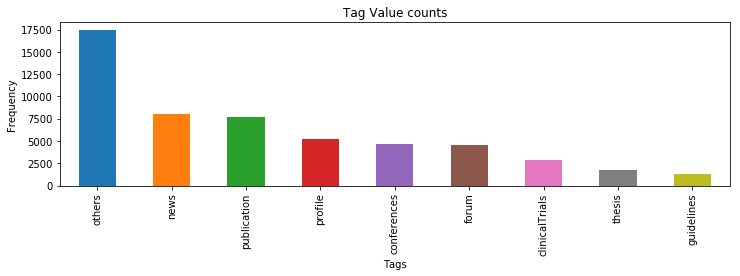

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
df.Tag.value_counts().plot('bar')
plt.title("Tag Value counts")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.show()

Observations:
1. This is an imbalannced data
    - we can see the others count is the highest
    - class clenicalTrails, Thesis and guidelines have low datapoints compared to others

Soln : we can use class weights in further models for make the data balanced 


In [63]:
# label encoding of tags
from sklearn.preprocessing import LabelEncoder
labelenc = LabelEncoder()
tags = labelenc.fit_transform(df.Tag.values)

In [64]:
df['TagLabel'] = tags

Observations
- we we not consider webpage_id as it is for joining the html data

### Train-test split

In [65]:
from sklearn.model_selection import train_test_split
# we will use scipy.sparse.hstack to stack the three 
from scipy.sparse import hstack

In [66]:
X = hstack((domain_counts,url_counts))
print(X.shape)

x_train, x_test , y_train , y_test = train_test_split(X, df['TagLabel'], test_size=0.18)

(53447, 188309)


In [67]:
y_train = y_train.values
y_test = y_test.values

In [68]:
# # One hot encoding For neural network
# from sklearn.preprocessing import OneHotEncoder
# onehot = OneHotEncoder()
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)
# y_train = onehot.fit_transform(y_train)
# y_test = onehot.transform(y_test)

In [69]:
# shape of y_train
y_train.shape
# this is 9 dim vector with approx 40K points 

(43826,)

### Random Model

In [70]:
print('shape of y_test : ',y_test.shape)

shape of y_test :  (9621,)


In [71]:
pred_rand = np.random.randint(low=0,high=8,size=(y_test.shape[0],))
pred_rand.shape

(9621,)

In [72]:
#np.argmax(y_test,axis=1).shape
min(y_test)

0

In [73]:
from sklearn.metrics import f1_score
#argmax = np.argmax(y_test,axis=1)
score = f1_score(y_test,pred_rand,average='weighted')
print(score)

0.12889422120086508


C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Observations:
- random model gave an extremely poor score of 0.12

### Machine Learning models

**1. Naive Bayes **

In [31]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
y_test.reshape(-1,1).shape

(9621, 1)

In [33]:
y_pred = nb.predict(x_test)
score = f1_score(y_test,y_pred,average='weighted')

In [34]:
print("score with naive bayes :", score)

score with naive bayes : 0.9230787799998124


In [35]:
# Getting test data
test_df = pd.read_csv("H:/ml_data/inno/test_nvPHrOx.csv")

In [36]:
test_df.columns

Index(['Webpage_id', 'Domain', 'Url'], dtype='object')

In [37]:
# processing domain and url
domain_list = []
for domain in test_df.Domain.values:
    url = []
    for word in domain.split("."):
        word = word.lower()
        url.append(word)
    domain_list.append(" ".join(url))

test_df['DomainClean'] = domain_list

domain_counts_test = domain_count_vect.transform(test_df.DomainClean.values)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [38]:
url_list = []
for url in test_df.Url.values:
    url = re.findall(r"[\w']+", url)
    temp = []
    for word in url:
        word.lower()
        if (word not in stop) and (word not in ["http","https","www","com"]):
            if (sno.stem(word) not in temp):
                temp.append(sno.stem(word))
    url_list.append(" ".join(temp))
    
test_df['UrlClean'] = url_list

url_counts_test = url_vect.transform(test_df.UrlClean.values)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [39]:
test_data = hstack((domain_counts_test,url_counts_test))

In [40]:
final_pred = nb.predict(test_data)

In [41]:
submission_data = list(zip(test_df.Webpage_id.values, labelenc.inverse_transform(final_pred)))

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
final = pd.DataFrame(submission_data,columns=["Webpage_id","Tag"])

In [43]:
final.to_csv("H:/ml_data/inno/NB1st.csv",index=False)

### Creating a basic neural network

In [27]:
import keras
from keras.utils import np_utils 

y_train = np_utils.to_categorical(y_train,9)
y_test = np_utils.to_categorical(y_test,9)

C:\Users\vivek\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
y_train.shape

(43826, 9)

In [29]:
y_test.shape

(9621, 9)

In [30]:
from keras.models import Sequential
from keras.layers import Dense

# some model parameters

output_dim = 9
input_dim = x_train.shape[1]

batch_size = 1000 
nb_epoch = 20

In [31]:
model = Sequential()
model.add(Dense(150, input_dim=input_dim, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(x_test, y_test)) 


Train on 43826 samples, validate on 9621 samples
Epoch 1/20
43826/43826 [==============================] - 103s 2ms/step - loss: 2.1755 - categorical_accuracy: 0.3103 - val_loss: 2.1508 - val_categorical_accuracy: 0.3289
Epoch 2/20
43826/43826 [==============================] - 106s 2ms/step - loss: 2.1302 - categorical_accuracy: 0.3252 - val_loss: 2.1075 - val_categorical_accuracy: 0.3289
Epoch 3/20
43826/43826 [==============================] - 106s 2ms/step - loss: 2.0910 - categorical_accuracy: 0.3252 - val_loss: 2.0713 - val_categorical_accuracy: 0.3289
Epoch 4/20
43826/43826 [==============================] - 106s 2ms/step - loss: 2.0585 - categorical_accuracy: 0.3252 - val_loss: 2.0411 - val_categorical_accuracy: 0.3289
Epoch 5/20
43000/43826 [============================>.] - ETA: 1s - loss: 2.0316 - categorical_accuracy: 0.3253

KeyboardInterrupt: 

In [409]:
from keras import backend as K

In [410]:
K.clear_session()

In [32]:
from keras.preprocessing.text import Tokenizer
texts = ['a a a', 'b b', 'c']
tokenizer = Tokenizer(num_words=2)
tokenizer.fit_on_texts(texts)
tokenizer.word_index


{'a': 1, 'b': 2, 'c': 3}

In [35]:
l = tokenizer.texts_to_sequences(texts)

3